# Capstone Project - Battle of the Neighborhoods

### Applied Data Science Capstone by IBM/Coursera

### Introduction

This project aims to identify those stations that would be best suited to tourists when visiting Singapore.

There are presently 124 MRT stations in Singapore, which form the backbone of the transport infrastructure for the country. The network is modern, clean, reliable and well connected. At the same time, Singapore weather is typically hot and humid which causes most people to focus their movements and activities to those places that are easy to get to and minimises walking outside.  Consequently, the location of these MRT stations is both a consequence of, and a contributing factor to, the types of venues and activities available nearby to their locations. Invariably there will be something of note nearby to any MRT station, however not all stations are made equally.

This analysis will attempt to identify the best stations for certain activities, and also how many hotels are nearby.

### Data

A list of MRT stations (both present and planned) can be found on Wikipedia.

Foursquare API can provide location-based venue information which can be used to explore areas adjacent to each active MRT station. 

Google maps can be used to determine geo-location (longitude, latitude) data for MRT stations.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files



import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Import Station data

I obtained Station data from Wikipedia and saved this down into a CSV file, which I will now load into a Dataframe

In [2]:
stations = pd.read_csv(r'C:\Users\Neil\Desktop\Singapore MRT stations.csv')

stations.head()

,Station,Latitude,Longitude
0,Admiralty,1.440609,103.800941
1,Aljunied,1.316416,103.882805
2,Ang Mo Kio,1.369985,103.849606
3,Bartley,1.342859,103.879682
4,Bayfront,1.281340,103.858947


### Checking the validity of the geo-location data relating to Singapore MRT stations

Here I have visualised Singapore using Folium map, and then overlay the station markers using the geo-location data imported above

In [3]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
address = 'Singapore, singapore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

Solving environment: ...working... done

# All requested packages already installed.

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


In [4]:
# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=11.5)

map_sg

In [5]:
# add markers to map
for lat, lng, station in zip(stations['Latitude'], stations['Longitude'], stations['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

The map above now correctly shows the locations of the MRT stations across Singapore

## NOTE: 

### given Foursquare API usage limitations, and security of my API credentials, I have saved the query results to a CSV and then used this CSV for the purposes of analysis.

####  I originally used API query code below in order to get the initial results, however in subsquent iterations and development of the analysis I used the data loaded from a CSV file, in order to reduce burden on my Foursquare API usage limits

### Call FourSquare API for venue information

In [ ]:
CLIENT_ID = 'XXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Here I now call the API for each station in the station list, and save this data to a list

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

sg_venues = getNearbyVenues(names=stations['Station'],
                                   latitudes=stations['Latitude'],
                                   longitudes=stations['Longitude']
                                  )


##### NOTE: 
To repeat, the code above was used for the original query but I have subsequently loaded the data from a CSV file in order to stay inside my Foursquare usage limits

### Loading Foursquare data from CSV:

In [6]:
sg_venues = pd.read_csv((r'C:\Users\Neil\Desktop\Foursquare results.csv'))
sg_venues = sg_venues.drop(columns=['Group','Unnamed: 0'])
sg_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Admiralty,1.440609,103.800941,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court
1,Admiralty,1.440609,103.800941,Starbucks,1.439761,103.800659,Coffee Shop
2,Admiralty,1.440609,103.800941,NTUC Fairprice,1.439955,103.800761,Supermarket
3,Admiralty,1.440609,103.800941,Prima Deli,1.440586,103.801595,Bakery
4,Admiralty,1.440609,103.800941,NTUC FairPrice,1.437707,103.797636,Supermarket


##### This is a preview of the results obtained from the API queries

In [7]:
print(sg_venues.shape)
sg_venues.head()

(4887, 7)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Admiralty,1.440609,103.800941,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court
1,Admiralty,1.440609,103.800941,Starbucks,1.439761,103.800659,Coffee Shop
2,Admiralty,1.440609,103.800941,NTUC Fairprice,1.439955,103.800761,Supermarket
3,Admiralty,1.440609,103.800941,Prima Deli,1.440586,103.801595,Bakery
4,Admiralty,1.440609,103.800941,NTUC FairPrice,1.437707,103.797636,Supermarket


##### Now I will look at the results according to Stations

In [8]:
sg_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station,,,,,,
Admiralty,5,5,5,5,5,5
Aljunied,49,49,49,49,49,49
Ang Mo Kio,40,40,40,40,40,40
Bartley,10,10,10,10,10,10
Bayfront,51,51,51,51,51,51
Beauty World,76,76,76,76,76,76
Bedok,61,61,61,61,61,61
Bedok North,18,18,18,18,18,18
Bedok Reservoir,8,8,8,8,8,8


In [9]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 325 uniques categories.


##### Again the above results are not easy to visualise as a table, so I will convert to a bar chart:

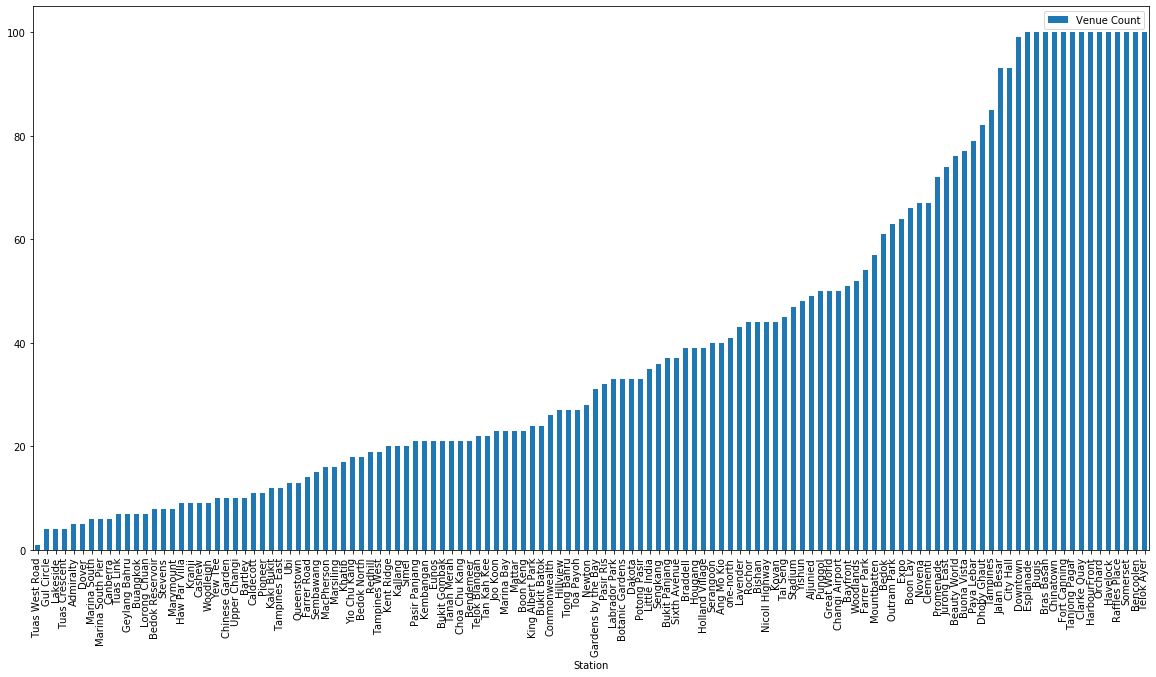

In [10]:
venuesplot = sg_venues.groupby('Station').count()
venuesplot = venuesplot.drop(columns=['Station Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
venuesplot = venuesplot.rename(columns={'Station Latitude': 'Venue Count'})
venuesplot = venuesplot.sort_values('Venue Count')
venuesplot.plot.bar(figsize=(20,10))

It is clear from the data that the density of venues varies from station to station.
It is noted from the chart above that some stations have more than 100 venues nearby, however this analysis has capped venues at 100

When viewed as a histogram (see below) it is apparent that stations typically support either a modest number of venues (< 50) or are densely surrounded (100+).

In [11]:
count, bin_edges = np.histogram(venuesplot)

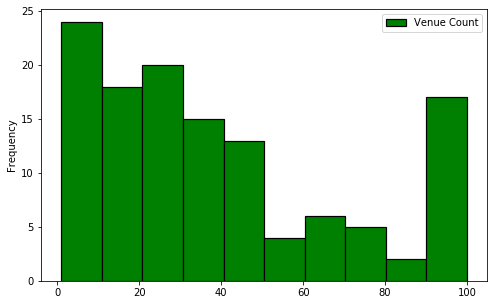

In [12]:
venuesplot.plot(kind='hist', figsize=(8, 5), color='green', edgecolor='black', linewidth=1.2)

Another way to visualise this data is simply at the category level, how many instances per category?

In [17]:
catcount = sg_venues.groupby('Venue Category').count()
catcount = catcount.drop(columns=['Station','Station Latitude','Station Longitude', 'Venue Latitude', 'Venue Longitude'])
catcount = catcount.rename(columns={'Venue': 'Venue Count'})
catcount = catcount.sort_values('Venue Count')
catcount.head()

,Venue Count
Venue Category,
Pastry Shop,1
Music Store,1
Nail Salon,1
Night Market,1
Non-Profit,1


In [19]:
catcounttop = catcount.sort_values('Venue Count', ascending=False)
catcounttop = catcounttop.head(n=20)
catcounttop.head()

,Venue Count
Venue Category,
Chinese Restaurant,246
Coffee Shop,243
Café,241
Japanese Restaurant,193
Food Court,183


In [20]:
catcountbot = catcount.sort_values('Venue Count', ascending=True)
catcountbot = catcountbot.head(n=20)
catcountbot.head()

,Venue Count
Venue Category,
Pastry Shop,1
Track,1
Tourist Information Center,1
Theme Restaurant,1
Temple,1


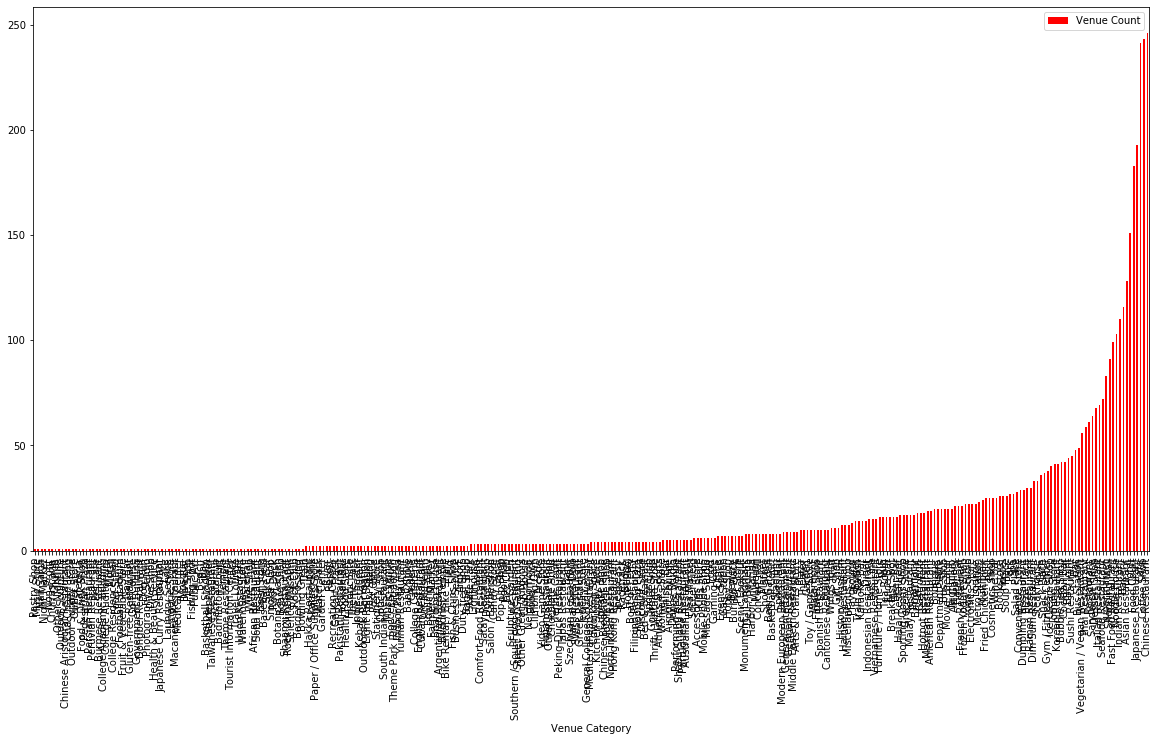

In [21]:
catcount.plot(kind='bar', figsize=(20,10), color='red')

There must be a way to consolidate these categories for better analysis

Start by finding the most common venues by each station

In [22]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add station column back to dataframe
sg_onehot['Station'] = sg_venues['Station'] 

# move station column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Station,Accessories Store,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cha Chaan Teng,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,College Cafeteria,College Residence Hall,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Event Space,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundry Service,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Macanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa

In [25]:
sg_grouped = sg_onehot.groupby('Station').mean().reset_index()
sg_grouped.head()

,Station,Accessories Store,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cha Chaan Teng,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,College Cafeteria,College Residence Hall,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Event Space,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundry Service,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Macanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Station'] = sg_grouped['Station']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Supermarket,Bakery,Food Court,Coffee Shop,Yunnan Restaurant,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
1,Aljunied,Chinese Restaurant,Noodle House,BBQ Joint,Coffee Shop,Food Court,Café,Asian Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Seafood Restaurant
2,Ang Mo Kio,Coffee Shop,Food Court,Dessert Shop,Bubble Tea Shop,Supermarket,Japanese Restaurant,Sandwich Place,Snack Place,Fried Chicken Joint,Noodle House
3,Bartley,Noodle House,Bus Station,Bus Stop,Seafood Restaurant,Indian Restaurant,Metro Station,Café,Soccer Field,Flower Shop,Filipino Restaurant
4,Bayfront,Hotel,Boutique,Theater,Lounge,Tea Room,Nightclub,Japanese Restaurant,Bridge,Waterfront,Chocolate Shop


Even looking at the sample of data above, it is easy to see that a number of categories could be consolidated for analysis.
For example, near to Aljunied station there are a number of restaurants appearing separately in the most common venues (e.g. Chinese Restaurant, Asian Restaurant, Dim Sum Restaurant) when in fact we may want to consider these in aggregate under the broader category of Restaurants.

This is particularly true when considered in light of the target audience (i.e. tourists) who are likely interested in the wider availability of restaurants as opposed to one particular cuisine type, although this would be an interesting area for further analysis subsequent to this project.

#### As a result, I set about to further aggregate the categories for the purposes of classification.

I started by looking for key words across the category names

In [28]:
sg_groupedsum = sg_onehot.groupby('Station').sum().reset_index()
sg_groupedsum.head()

,Station,Accessories Store,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cha Chaan Teng,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,College Cafeteria,College Residence Hall,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Event Space,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundry Service,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Macanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa

In [29]:
listcats = list(sg_groupedsum)

In [30]:
from collections import Counter
catcount = Counter(listcats)
catcount

Counter({'Station': 1,
         'Accessories Store': 1,
         'African Restaurant': 1,
         'Airport': 1,
         'Airport Lounge': 1,
         'American Restaurant': 1,
         'Arcade': 1,
         'Argentinian Restaurant': 1,
         'Art Gallery': 1,
         'Art Museum': 1,
         'Arts & Crafts Store': 1,
         'Asian Restaurant': 1,
         'Athletics & Sports': 1,
         'Australian Restaurant': 1,
         'BBQ Joint': 1,
         'Baby Store': 1,
         'Badminton Court': 1,
         'Bagel Shop': 1,
         'Bakery': 1,
         'Bank': 1,
         'Bar': 1,
         'Baseball Field': 1,
         'Basketball Court': 1,
         'Basketball Stadium': 1,
         'Bay': 1,
         'Beach': 1,
         'Bed & Breakfast': 1,
         'Beer Bar': 1,
         'Beer Garden': 1,
         'Beer Store': 1,
         'Bike Rental / Bike Share': 1,
         'Bistro': 1,
         'Board Shop': 1,
         'Boarding House': 1,
         'Boat or Ferry': 1,
         'B

In [31]:
listwords = []
l = 0
for cat in listcats:
    #print(listcats[l].split(" "))
    lw = listcats[l].split(" ")
    
    #for word in lw:
    listwords.extend((lw)) 
    l = l + 1

print(listwords)

['Station', 'Accessories', 'Store', 'African', 'Restaurant', 'Airport', 'Airport', 'Lounge', 'American', 'Restaurant', 'Arcade', 'Argentinian', 'Restaurant', 'Art', 'Gallery', 'Art', 'Museum', 'Arts', '&', 'Crafts', 'Store', 'Asian', 'Restaurant', 'Athletics', '&', 'Sports', 'Australian', 'Restaurant', 'BBQ', 'Joint', 'Baby', 'Store', 'Badminton', 'Court', 'Bagel', 'Shop', 'Bakery', 'Bank', 'Bar', 'Baseball', 'Field', 'Basketball', 'Court', 'Basketball', 'Stadium', 'Bay', 'Beach', 'Bed', '&', 'Breakfast', 'Beer', 'Bar', 'Beer', 'Garden', 'Beer', 'Store', 'Bike', 'Rental', '/', 'Bike', 'Share', 'Bistro', 'Board', 'Shop', 'Boarding', 'House', 'Boat', 'or', 'Ferry', 'Bookstore', 'Border', 'Crossing', 'Botanical', 'Garden', 'Boutique', 'Bowling', 'Alley', 'Bowling', 'Green', 'Breakfast', 'Spot', 'Brewery', 'Bridge', 'Bubble', 'Tea', 'Shop', 'Buddhist', 'Temple', 'Buffet', 'Building', 'Burger', 'Joint', 'Burmese', 'Restaurant', 'Burrito', 'Place', 'Bus', 'Line', 'Bus', 'Station', 'Bus', 'St

In [32]:
from collections import Counter
catcount = Counter(listwords)
catcount

Counter({'Station': 6,
         'Accessories': 1,
         'Store': 30,
         'African': 1,
         'Restaurant': 67,
         'Airport': 2,
         'Lounge': 3,
         'American': 1,
         'Arcade': 1,
         'Argentinian': 1,
         'Art': 3,
         'Gallery': 1,
         'Museum': 4,
         'Arts': 3,
         '&': 9,
         'Crafts': 1,
         'Asian': 1,
         'Athletics': 1,
         'Sports': 3,
         'Australian': 1,
         'BBQ': 1,
         'Joint': 4,
         'Baby': 1,
         'Badminton': 1,
         'Court': 4,
         'Bagel': 1,
         'Shop': 30,
         'Bakery': 1,
         'Bank': 1,
         'Bar': 13,
         'Baseball': 1,
         'Field': 3,
         'Basketball': 2,
         'Stadium': 4,
         'Bay': 1,
         'Beach': 1,
         'Bed': 1,
         'Breakfast': 3,
         'Beer': 3,
         'Garden': 5,
         'Bike': 2,
         'Rental': 1,
         '/': 13,
         'Share': 1,
         'Bistro': 1,
         '

In [33]:

{k: v for k, v in sorted(catcount.items(), key=lambda item: item[1])}


{'Accessories': 1,
 'African': 1,
 'American': 1,
 'Arcade': 1,
 'Argentinian': 1,
 'Gallery': 1,
 'Crafts': 1,
 'Asian': 1,
 'Athletics': 1,
 'Australian': 1,
 'BBQ': 1,
 'Baby': 1,
 'Badminton': 1,
 'Bagel': 1,
 'Bakery': 1,
 'Bank': 1,
 'Baseball': 1,
 'Bay': 1,
 'Beach': 1,
 'Bed': 1,
 'Rental': 1,
 'Share': 1,
 'Bistro': 1,
 'Board': 1,
 'Boarding': 1,
 'Boat': 1,
 'or': 1,
 'Ferry': 1,
 'Bookstore': 1,
 'Border': 1,
 'Crossing': 1,
 'Botanical': 1,
 'Boutique': 1,
 'Alley': 1,
 'Green': 1,
 'Brewery': 1,
 'Bridge': 1,
 'Bubble': 1,
 'Buddhist': 1,
 'Buffet': 1,
 'Burger': 1,
 'Burmese': 1,
 'Burrito': 1,
 'Line': 1,
 'Stop': 1,
 'Business': 1,
 'Canal': 1,
 'Candy': 1,
 'Cantonese': 1,
 'Casino': 1,
 'Cha': 1,
 'Chaan': 1,
 'Teng': 1,
 'Aristocrat': 1,
 'Chocolate': 1,
 'Church': 1,
 'Churrascaria': 1,
 'Clothing': 1,
 'Cocktail': 1,
 'Coffee': 1,
 'Academic': 1,
 'Auditorium': 1,
 'Residence': 1,
 'Comfort': 1,
 'Concert': 1,
 'Convenience': 1,
 'Cosmetics': 1,
 'Coworking': 1,


In [34]:
wordscounted = pd.DataFrame.from_dict(catcount, orient='index',columns =['Count'])

In [35]:
print("The number of words: ",  len(wordscounted.index))

The number of words:  372


In [36]:
wordsbar = wordscounted.sort_values(by='Count',ascending=False)

In [37]:
#wordsbar = wordsbar.head(n=20)
wordsbar.index.names = ['KeyWord']
wordsbar

,Count
KeyWord,
Restaurant,67
Store,30
Shop,30
Bar,13
/,13
Food,10
&,9
Place,7
Station,6


In [38]:
categorydata = pd.DataFrame(columns=['KeyWord','Count','Instance'])
categorydata

,KeyWord,Count,Instance


In [39]:
categorydata = pd.DataFrame(columns=['KeyWord','Count','Instance'])

for items in wordsbar.index:
    count = len(sg_venues[sg_venues['Venue Category'].str.contains(items)])
    instance = wordsbar.loc[items]['Count']

    categorydata = categorydata.append({'KeyWord' : items , 'Count' : count, 'Instance' : instance} , ignore_index=True)

categorydata = categorydata.sort_values(by='Count', axis=0, ascending=False)
categorydata

,KeyWord,Count,Instance
0,Restaurant,1559,67
2,Shop,637,30
285,or,406,1
5,Food,304,10
27,Chinese,251,3
232,Coffee,243,1
50,Café,242,2
1,Store,232,30
3,Bar,203,13
7,Place,196,7


##### HERE I AM PLOTTING THE INSTANCES OF A KEY WORD ACROSS THE CATEGORY NAMES

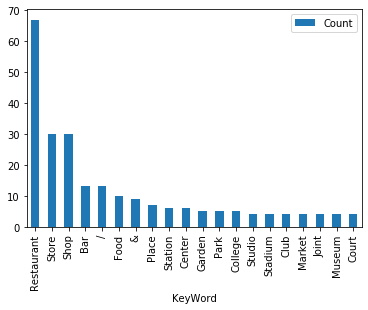

In [40]:
wordsbarplot = wordsbar.head(n=20)
wordsbarplot.plot.bar()

There are some clear key words that appear a lot in the category names

The keyword ‘Restaurant’ is by far the most common, appearing in almost 70 different venue category names. However even from the chart above it is possible to infer an aggregation opportunity inherent in the keywords, because alongside ‘Restaurant’ we can also see ‘Food’, ‘Bar’ and ‘Club’ amongst others. Clearly there is merit in aggregating certain words to form more coherent groupings.

Given the focus of this project and the needs of tourists, I created a set of major groups to which each venue category would be broadly assigned:


-	Socialising (restaurants, bars, clubs etc)
-	Shopping & Sightseeing (shopping malls, theatres, major sights etc)
-	Sports & Recreation (sports facilities, parks etc)
-	Attending courses, studying (universities, colleges etc)
-	Relaxing at the Hotel (hotels, motels etc)
-	Other (any other venues not fitting in to the above categories e.g. car park)


These groups are designed to broadly reflect the main types of activity that a tourist may be in Singapore to undertake. 
As a result of grouping the venues into these categories it is much easier to see the density of venues and what purposes they serve.


### Adding category group to each venue

I created a CSV file with categories of key words grouped according to those defined above:

Here I load them into a dataframe

In [41]:
categoryshop = pd.read_excel(r'C:\Users\Neil\Desktop\Categories of Venue.xlsx', sheet_name='shop')
categorysport = pd.read_excel(r'C:\Users\Neil\Desktop\Categories of Venue.xlsx', sheet_name='sport')
categorysocial = pd.read_excel(r'C:\Users\Neil\Desktop\Categories of Venue.xlsx', sheet_name='social')
categorystudent = pd.read_excel(r'C:\Users\Neil\Desktop\Categories of Venue.xlsx', sheet_name='student')
categoryhotels = pd.read_excel(r'C:\Users\Neil\Desktop\Categories of Venue.xlsx', sheet_name='hotels')

In [42]:
categoryshop.head()

,Word
0,Arcade
1,Art
2,Arts
3,Auditorium
4,Bookstore


In [43]:
categorysport.head()

,Word
0,Athletics
1,Badminton
2,Baseball
3,Basketball
4,Boat


In [44]:
categorysocial.head()

,Word
0,Bar
1,Beer
2,Bistro
3,Bodega
4,Breakfast


In [45]:
categorystudent.head()

,Word
0,Academic
1,College
2,School
3,Student
4,University


In [46]:
categoryhotels.head()

,Word
0,Hostel
1,Hotel
2,Motel
3,Resort


Now I will add these group tags to the underlying venue data

In [47]:
sg_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Admiralty,1.440609,103.800941,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court
1,Admiralty,1.440609,103.800941,Starbucks,1.439761,103.800659,Coffee Shop
2,Admiralty,1.440609,103.800941,NTUC Fairprice,1.439955,103.800761,Supermarket
3,Admiralty,1.440609,103.800941,Prima Deli,1.440586,103.801595,Bakery
4,Admiralty,1.440609,103.800941,NTUC FairPrice,1.437707,103.797636,Supermarket


In [48]:
venue_cat = sg_venues.loc[0]['Venue Category']

In [49]:
#venuesgroups = []
sg_venues["Group"] = np.nan

for x in sg_venues.index:
    notfound = True
    vencat = sg_venues.loc[x]['Venue Category']
    
    if notfound == True:
        for i in categorysocial.index:
            group = categorysocial.loc[i]['Word']
            if group in vencat:
                sg_venues.loc[x,'Group'] = 'Social'
                #venuesgroups.append('Social')
                notfound = False
                     
    if notfound == True:
        for i in categoryshop.index:
            group = categoryshop.loc[i]['Word']
            if group in vencat:
                sg_venues.loc[x,'Group'] = 'Shopping/Sightseeing'
                #venuesgroups.append('Shopping/Sightseeing')
                notfound = False

    if notfound == True:
        for i in categorysport.index:
            group = categorysport.loc[i]['Word']
            if group in vencat:
                sg_venues.loc[x,'Group'] = 'Sport/Recreation'
                #venuesgroups.append('Sport/Recreation')
                notfound = False

    if notfound == True:
        for i in categoryhotels.index:
            group = categoryhotels.loc[i]['Word']
            if group in vencat:
                sg_venues.loc[x,'Group'] = 'Hotels'
                #venuesgroups.append('Hotels')
                notfound = False

    if notfound == True:
        for i in categorystudent.index:
            group = categorystudent.loc[i]['Word']
            if group in vencat:
                sg_venues.loc[x,'Group'] = 'Students'
                #venuesgroups.append('Students')
                notfound = False
                           
    if notfound == True:
        sg_venues.loc[x,'Group'] = 'Other'
        #venuesgroups.append('Other')
         

Now you can see the Group tag on the end of the Dataframe:

In [50]:
sg_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Group
0,Admiralty,1.440609,103.800941,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court,Social
1,Admiralty,1.440609,103.800941,Starbucks,1.439761,103.800659,Coffee Shop,Social
2,Admiralty,1.440609,103.800941,NTUC Fairprice,1.439955,103.800761,Supermarket,Other
3,Admiralty,1.440609,103.800941,Prima Deli,1.440586,103.801595,Bakery,Other
4,Admiralty,1.440609,103.800941,NTUC FairPrice,1.437707,103.797636,Supermarket,Other


Now we can better visualise these aggregated results:

In [54]:
groupcount = sg_venues.groupby('Group').count()
groupcount = groupcount.drop(columns=['Station','Station Latitude','Station Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
groupcount = groupcount.rename(columns={'Venue': 'Venue Count'})
groupcount = groupcount.sort_values('Venue Count')
groupcount.head()

,Venue Count
Group,
Students,6
Hotels,180
Sport/Recreation,286
Shopping/Sightseeing,526
Other,901


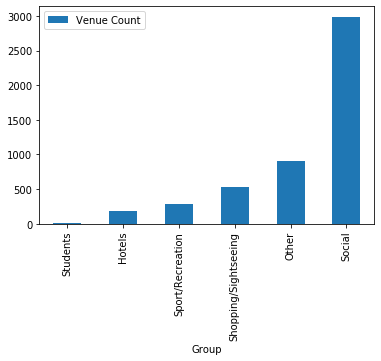

In [55]:
groupcount.plot.bar()

##### As can be seen above the social category is the most popular in Singapore

In [56]:
sg_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Group
Station,,,,,,,
Admiralty,5,5,5,5,5,5,5
Aljunied,49,49,49,49,49,49,49
Ang Mo Kio,40,40,40,40,40,40,40
Bartley,10,10,10,10,10,10,10
Bayfront,51,51,51,51,51,51,51
Beauty World,76,76,76,76,76,76,76
Bedok,61,61,61,61,61,61,61
Bedok North,18,18,18,18,18,18,18
Bedok Reservoir,8,8,8,8,8,8,8


In [57]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 325 uniques categories.


(No loss of data after aggregation efforts)

##### Now I will re-run the 'most common venue' grouping using the new aggregations

In [58]:
# one hot encoding
sg_onehotgroup = pd.get_dummies(sg_venues[['Group']], prefix="", prefix_sep="")

# add station column back to dataframe
sg_onehotgroup['Station'] = sg_venues['Station'] 

# move station column to the first column
fixed_columns = [sg_onehotgroup.columns[-1]] + list(sg_onehotgroup.columns[:-1])
sg_onehotgroup = sg_onehotgroup[fixed_columns]

sg_onehotgroup.head()

,Station,Hotels,Other,Shopping/Sightseeing,Social,Sport/Recreation,Students
0,Admiralty,0,0,0,1,0,0
1,Admiralty,0,0,0,1,0,0
2,Admiralty,0,1,0,0,0,0
3,Admiralty,0,1,0,0,0,0
4,Admiralty,0,1,0,0,0,0


In [59]:
sg_grouped = sg_onehotgroup.groupby('Station').mean().reset_index()
sg_grouped

,Station,Hotels,Other,Shopping/Sightseeing,Social,Sport/Recreation,Students
0,Admiralty,0.000000,0.600000,0.000000,0.400000,0.000000,0.000000
1,Aljunied,0.020408,0.163265,0.020408,0.775510,0.020408,0.000000
2,Ang Mo Kio,0.000000,0.275000,0.150000,0.525000,0.050000,0.000000
3,Bartley,0.000000,0.400000,0.000000,0.500000,0.100000,0.000000
4,Bayfront,0.098039,0.274510,0.235294,0.313725,0.078431,0.000000
5,Beauty World,0.000000,0.184211,0.039474,0.763158,0.013158,0.000000
6,Bedok,0.000000,0.180328,0.114754,0.688525,0.016393,0.000000
7,Bedok North,0.000000,0.555556,0.000000,0.388889,0.055556,0.000000
8,Bedok Reservoir,0.000000,0.250000,0.000000,0.625000,0.125000,0.000000
9,Bencoolen,0.090000,0.070000,0.260000,0.530000,0.050000,0.000000


In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [61]:
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Station'] = sg_grouped['Station']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Admiralty,Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels
1,Aljunied,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students
2,Ang Mo Kio,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
3,Bartley,Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
4,Bayfront,Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students


It is now becoming clearer to understand what kinds of venues exist around each station.  We can go another step further to cluster the stations using machine learning.

## Cluster Stations

In order to cluster the stations, I decided to use the k-means algorithm which is one of the most common methods of unsupervised machine learning for clustering. Further, because of its unsupervised nature I utilised the elbow method to determine an optimum number of clusters for the algorithm to solve for.

First we will use the K Elbow method in order to understand the optimum K value for use in K means clustering

In [62]:
sg_grouped_clustering = sg_grouped.drop('Station', 1)
list(sg_grouped_clustering)

['Hotels',
 'Other',
 'Shopping/Sightseeing',
 'Social',
 'Sport/Recreation',
 'Students']

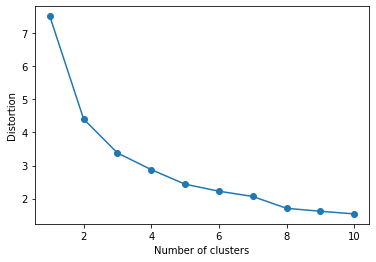

In [63]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(sg_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Although the elbow is not pronounced I am taking k=3 as the optimum point as it appears the best number of clusters

I will now set up the Kmeans algorithm with k=3

In [64]:
# set number of clusters
kclusters = 3

In [66]:
sg_grouped_clustering.head()

,Hotels,Other,Shopping/Sightseeing,Social,Sport/Recreation,Students
0,0.000000,0.600000,0.000000,0.400000,0.000000,0.0
1,0.020408,0.163265,0.020408,0.775510,0.020408,0.0
2,0.000000,0.275000,0.150000,0.525000,0.050000,0.0
3,0.000000,0.400000,0.000000,0.500000,0.100000,0.0
4,0.098039,0.274510,0.235294,0.313725,0.078431,0.0


In [67]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 0, 1, 0, 2, 2, 1, 2, 0])

#### I am now going to add the cluster result for each station into the core Dataframe to continue analysis



In [68]:
neighborhoods_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Admiralty,Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels
1,Aljunied,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students
2,Ang Mo Kio,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
3,Bartley,Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
4,Bayfront,Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students


In [69]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = stations

# merge to add latitude/longitude for each station
sg_merged = sg_merged.join(neighborhoods_venues_sorted.set_index('Station'), on='Station')

sg_merged.head() 

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Admiralty,1.440609,103.800941,1,Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels
1,Aljunied,1.316416,103.882805,2,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students
2,Ang Mo Kio,1.369985,103.849606,0,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
3,Bartley,1.342859,103.879682,1,Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
4,Bayfront,1.281340,103.858947,0,Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students


## Now I will examine the Clusters

#### Cluster 1

In [73]:
clust1set = sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]
clust1set = clust1set.reset_index(drop=True)
clust1set

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Ang Mo Kio,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
1,Bayfront,Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students
2,Bencoolen,Social,Shopping/Sightseeing,Hotels,Other,Sport/Recreation,Students
3,Bendemeer,Social,Other,Hotels,Sport/Recreation,Shopping/Sightseeing,Students
4,Bishan,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
5,Bras Basah,Social,Shopping/Sightseeing,Hotels,Other,Sport/Recreation,Students
6,Bukit Gombak,Social,Sport/Recreation,Other,Shopping/Sightseeing,Students,Hotels
7,Changi Airport,Social,Other,Shopping/Sightseeing,Sport/Recreation,Hotels,Students
8,City Hall,Social,Shopping/Sightseeing,Other,Hotels,Sport/Recreation,Students
9,Dhoby Ghaut,Social,Shopping/Sightseeing,Sport/Recreation,Hotels,Other,Students


There is a lot of Social and Shopping, Sightseeing instance above

In [74]:
clustername1 = 'Social, Shopping & Sightseeing'

#### Cluster 2

In [75]:
clust2set = sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]
clust2set = clust2set.reset_index(drop=True)
clust2set

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Admiralty,Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels
1,Bartley,Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
2,Bedok North,Other,Social,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
3,Buangkok,Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels
4,Caldecott,Shopping/Sightseeing,Other,Sport/Recreation,Students,Social,Hotels
5,Cashew,Other,Social,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
6,Farrer Road,Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
7,Gul Circle,Other,Social,Shopping/Sightseeing,Students,Sport/Recreation,Hotels
8,Joo Koon,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
9,Kranji,Sport/Recreation,Social,Other,Students,Shopping/Sightseeing,Hotels


There is a large number of Sport/Recreation instances above

In [76]:
clustername2 = 'Sports, Recreation & Other'

#### Cluster 3

In [77]:
sg_merged.loc[sg_merged['Cluster Labels'] == 2, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
1,Aljunied,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students
5,Beauty World,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
6,Bedok,Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels
8,Bedok Reservoir,Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels
12,Boon Keng,Social,Other,Shopping/Sightseeing,Students,Sport/Recreation,Hotels
13,Boon Lay,Social,Other,Sport/Recreation,Shopping/Sightseeing,Students,Hotels
14,Botanic Gardens,Social,Shopping/Sightseeing,Other,Sport/Recreation,Students,Hotels
15,Braddell,Social,Other,Shopping/Sightseeing,Students,Sport/Recreation,Hotels
18,Bugis,Social,Shopping/Sightseeing,Other,Hotels,Sport/Recreation,Students
19,Bukit Batok,Social,Other,Sport/Recreation,Shopping/Sightseeing,Students,Hotels


There is lots of Social and Other above

In [78]:
clustername3 = 'Social & Other'

I have mapped the clusters to names above, and will add these into the dataset for inclusion in the map

- Cluster 1 = Social, Shopping & Sightseeing
- Cluster 2 = Sports, Recreation & Other
- Cluster 3 = Social & Other

In [79]:
sg_clusters = sg_merged

In [80]:
sg_clusters["Cluster Numbers"] = sg_clusters["Cluster Labels"]
sg_clusters["Cluster Labels"].replace({0: clustername1, 1: clustername2, 2: clustername3}, inplace=True)

In [81]:
sg_clusters.head()

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Cluster Numbers
0,Admiralty,1.440609,103.800941,"Sports, Recreation & Other",Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels,1
1,Aljunied,1.316416,103.882805,Social & Other,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students,2
2,Ang Mo Kio,1.369985,103.849606,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels,0
3,Bartley,1.342859,103.879682,"Sports, Recreation & Other",Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels,1
4,Bayfront,1.281340,103.858947,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students,0


I will set the map to show stations clustered as above, with the name and cluster name in the detail

In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbows = {1:'darkblue',2:'darkgreen',3:'darkred','high':'orange','medium':'grey','low':'yellow', 'NaN': 'darkgrey'}


# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, clustnum in zip(sg_clusters['Latitude'], sg_clusters['Longitude'], sg_clusters['Station'], sg_clusters['Cluster Labels'], sg_clusters['Cluster Numbers']):
    label = folium.Popup(str(poi) + ': ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbows[clustnum+1],
        fill=True,
        fill_color=rainbows[clustnum+1],
        fill_opacity=1).add_to(map_clusters)

map_clusters

### Add Hotel density to the station data

For visiting tourists, it may also be useful to understand where hotels are located, and one way to assess this is by the density of hotels around each station. I again used a Dataframe to determine the count of hotels near each station and then plotted the results as follows.

Now I want to enrich the analysis by tagging stations according to how many hotels are nearby

In [83]:
sg_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Group
0,Admiralty,1.440609,103.800941,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court,Social
1,Admiralty,1.440609,103.800941,Starbucks,1.439761,103.800659,Coffee Shop,Social
2,Admiralty,1.440609,103.800941,NTUC Fairprice,1.439955,103.800761,Supermarket,Other
3,Admiralty,1.440609,103.800941,Prima Deli,1.440586,103.801595,Bakery,Other
4,Admiralty,1.440609,103.800941,NTUC FairPrice,1.437707,103.797636,Supermarket,Other


In [84]:
hotelslist = sg_venues[sg_venues['Group']=='Hotels']
hotelslist

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Group
50,Aljunied,1.316416,103.882805,ibis Budget,1.312375,103.881204,Hotel,Hotels
104,Bayfront,1.281340,103.858947,Marina Bay Sands,1.283190,103.859124,Resort,Hotels
106,Bayfront,1.281340,103.858947,Marina Bay Sands Hotel,1.282932,103.860369,Hotel,Hotels
108,Bayfront,1.281340,103.858947,Tower 1 Marina Bay Sands Hotel,1.282213,103.859881,Hotel,Hotels
121,Bayfront,1.281340,103.858947,Tower 2 Marina Bay Sands Hotel,1.283293,103.860657,Hotel,Hotels
138,Bayfront,1.281340,103.858947,Tower 3 Marina Bay Sands Hotel,1.284452,103.860902,Hotel,Hotels
324,Bencoolen,1.298439,103.849946,30 Bencoolen,1.298443,103.850391,Hotel,Hotels
331,Bencoolen,1.298439,103.849946,Mi Hotel,1.298977,103.850110,Hotel,Hotels
335,Bencoolen,1.298439,103.849946,Rendezvous Hotel Singapore,1.298585,103.849061,Hotel,Hotels
352,Bencoolen,1.298439,103.849946,YMCA International House,1.297946,103.847967,Hotel,Hotels


Identify and count how many hotels per each station

In [85]:
# one hot encoding
sg_onehothotels = pd.get_dummies(hotelslist[['Group']], prefix="", prefix_sep="")

# add station column back to dataframe
sg_onehothotels['Station'] = hotelslist['Station'] 

# move station column to the first column
fixed_columns = [sg_onehothotels.columns[-1]] + list(sg_onehothotels.columns[:-1])
sg_onehothotels = sg_onehothotels[fixed_columns]

sg_onehothotels.head()

,Station,Hotels
50,Aljunied,1
104,Bayfront,1
106,Bayfront,1
108,Bayfront,1
121,Bayfront,1


In [86]:
hotelcount = sg_onehothotels.groupby('Station').sum()

We can now see the number of hotels around each station

In [87]:
hotelcount.head()

,Hotels
Station,
Aljunied,1
Bayfront,5
Bencoolen,9
Bendemeer,3
Bras Basah,11


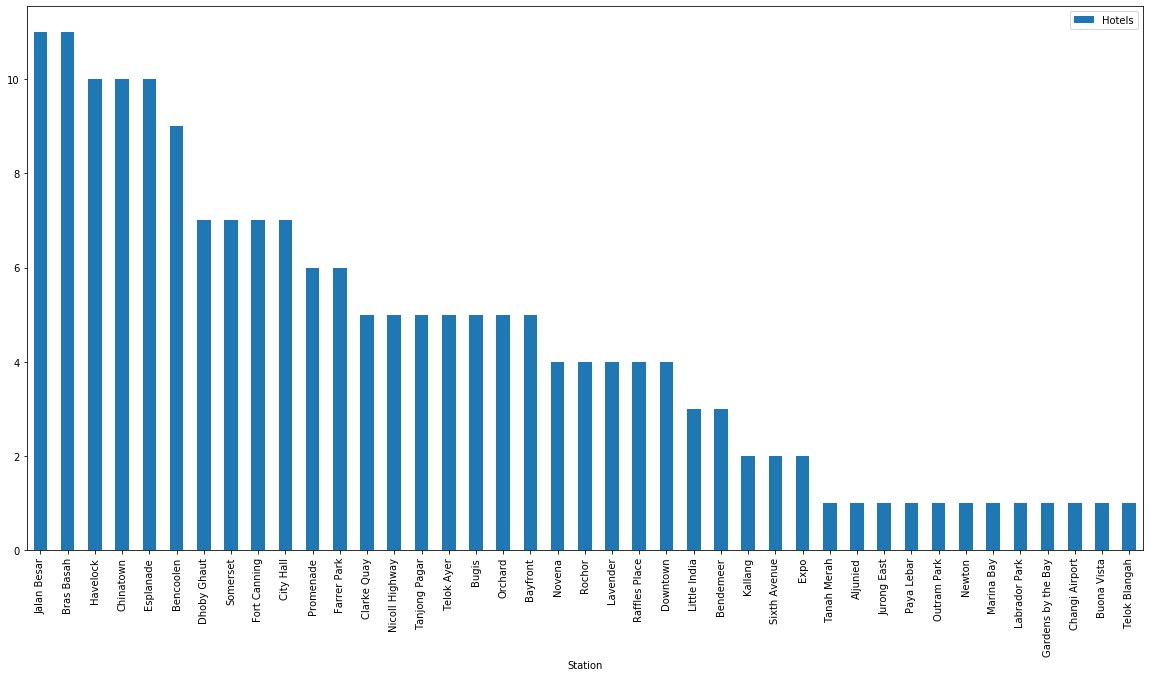

In [88]:
hotelsbarplot = hotelcount.sort_values('Hotels',ascending=False)
hotelsbarplot.plot.bar(figsize=(20,10))

Turning this into a histogram might help work out some broad density buckets

In [89]:
count, bin_edges = np.histogram(hotelcount)

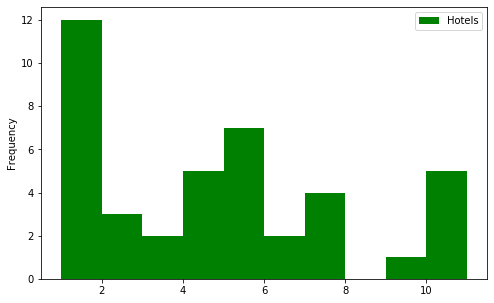

In [90]:
hotelcount.plot(kind='hist', figsize=(8, 5), color='green')

Looking at the histogram above there seem to be 3 rough groupings:
- Low: 0-4
- Medium: 5-8
- High: 9-12
I will add these groupings to the data file

add hotel count category to the data

In [91]:
hotelcount.head()

,Hotels
Station,
Aljunied,1
Bayfront,5
Bencoolen,9
Bendemeer,3
Bras Basah,11


In [92]:
hotelcount["Group"] = np.nan

for x in hotelcount.index:
    hotcount = hotelcount.loc[x]['Hotels']
    
    if hotcount < 5:
        hotelcount.loc[x,'Group'] = 'Low'

    elif hotcount < 9:
        hotelcount.loc[x,'Group'] = 'Medium'
        
    else:
        hotelcount.loc[x,'Group'] = 'High'


In [93]:
hotelcount.head()

,Hotels,Group
Station,,
Aljunied,1,Low
Bayfront,5,Medium
Bencoolen,9,High
Bendemeer,3,Low
Bras Basah,11,High


We can now see the count of hotels and the density tag (low, medium, high)

### NOW WE WILL CREATE THE VENUE DENSITY RANKINGS 

I want to count for each station how many venues are in the local vicinity and are in the category types that the station is clustered against

First I will figure out how many venues for each Group for each station:

In [97]:
venuedensity = sg_venues.groupby(['Station','Group']).count().reset_index()
venuedensity = venuedensity.drop(columns=['Station Latitude','Station Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
venuedensity = venuedensity.rename(columns={'Venue': 'Venue Count'})
venuedensity.head()

,Station,Group,Venue Count
0,Admiralty,Other,3
1,Admiralty,Social,2
2,Aljunied,Hotels,1
3,Aljunied,Other,8
4,Aljunied,Shopping/Sightseeing,1


e.g. Admiralty 'Other' is 3 venues in total

Now bring in the cluster numbers so we can focus on relevant groups for each cluster

In [98]:
clusterdensity = sg_clusters.drop(columns=['Latitude','Longitude', 'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue',])

In [99]:
clusterdensity.head()

,Station,Cluster Numbers
0,Admiralty,1
1,Aljunied,2
2,Ang Mo Kio,0
3,Bartley,1
4,Bayfront,0


In [100]:
venuedensity.query("Station == 'Admiralty'")["Venue Count"].sum()

5

In [101]:
venuedensity.groupby(["Station","Group"])["Venue Count"].sum()


Station             Group               
Admiralty           Other                    3
                    Social                   2
Aljunied            Hotels                   1
                    Other                    8
                    Shopping/Sightseeing     1
                    Social                  38
                    Sport/Recreation         1
Ang Mo Kio          Other                   11
                    Shopping/Sightseeing     6
                    Social                  21
                    Sport/Recreation         2
Bartley             Other                    4
                    Social                   5
                    Sport/Recreation         1
Bayfront            Hotels                   5
                    Other                   14
                    Shopping/Sightseeing    12
                    Social                  16
                    Sport/Recreation         4
Beauty World        Other                   14
                   

In [102]:
venuedensity.head()

,Station,Group,Venue Count
0,Admiralty,Other,3
1,Admiralty,Social,2
2,Aljunied,Hotels,1
3,Aljunied,Other,8
4,Aljunied,Shopping/Sightseeing,1


In [103]:
df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != 'Aljunied')].index)
df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Other')].index)

C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [104]:
df_new.head()

,Station,Group,Venue Count
3,Aljunied,Other,8


The following code now tests each station against cluster number so that it adds up how many venues for each station depending upon which cluster it is in (and therefore which activities it is best known for)

In [105]:
clusterdensity["Venue Density"] = np.nan

for x in clusterdensity.index:
    venden = 0 
    stationname = clusterdensity.loc[x]['Station']
    clusternum = clusterdensity.loc[x]['Cluster Numbers']
    
    #cluster number 0 is Social, Shopping & Sightseeing
    if clusternum == 0:
        df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != stationname)].index)
        df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Social')].index)        
        venden = df_new['Venue Count'].sum()        
                
        df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != stationname)].index)
        df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Shopping/Sightseeing')].index)        
        venden = venden + df_new['Venue Count'].sum()          
    
    #cluster number 1 is Sports, Recreation & Other
    elif clusternum == 1:
        df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != stationname)].index)
        df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Sport/Recreation')].index)        
        venden = df_new['Venue Count'].sum()        
                
        df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != stationname)].index)
        df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Other')].index)        
        venden = venden + df_new['Venue Count'].sum()   
        
    #cluster number 2 is Social & Other
    elif clusternum == 2:
        df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != stationname)].index)
        df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Social')].index)        
        venden = df_new['Venue Count'].sum()        
                
        df_new = venuedensity.drop(venuedensity[(venuedensity['Station'] != stationname)].index)
        df_new = df_new.drop(df_new[(venuedensity['Group'] != 'Other')].index)        
        venden = venden + df_new['Venue Count'].sum()       
    
    
    clusterdensity.loc[x,'Venue Density'] = venden
                
                

C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Neil\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [106]:
clusterdensity.head()

,Station,Cluster Numbers,Venue Density
0,Admiralty,1,3.0
1,Aljunied,2,46.0
2,Ang Mo Kio,0,27.0
3,Bartley,1,5.0
4,Bayfront,0,28.0


So for each station we now have the density of venues according to the cluster number (e.g. admiralty is cluster 1 i.e. sports, recreation & other....and there are 3 such venues around Admiralty therefore it has a venue density of 3)

I have now plotted the different cluster groups to see the density around respective stations:

### Venue density for cluster 1 Social, Shopping & Sightseeing

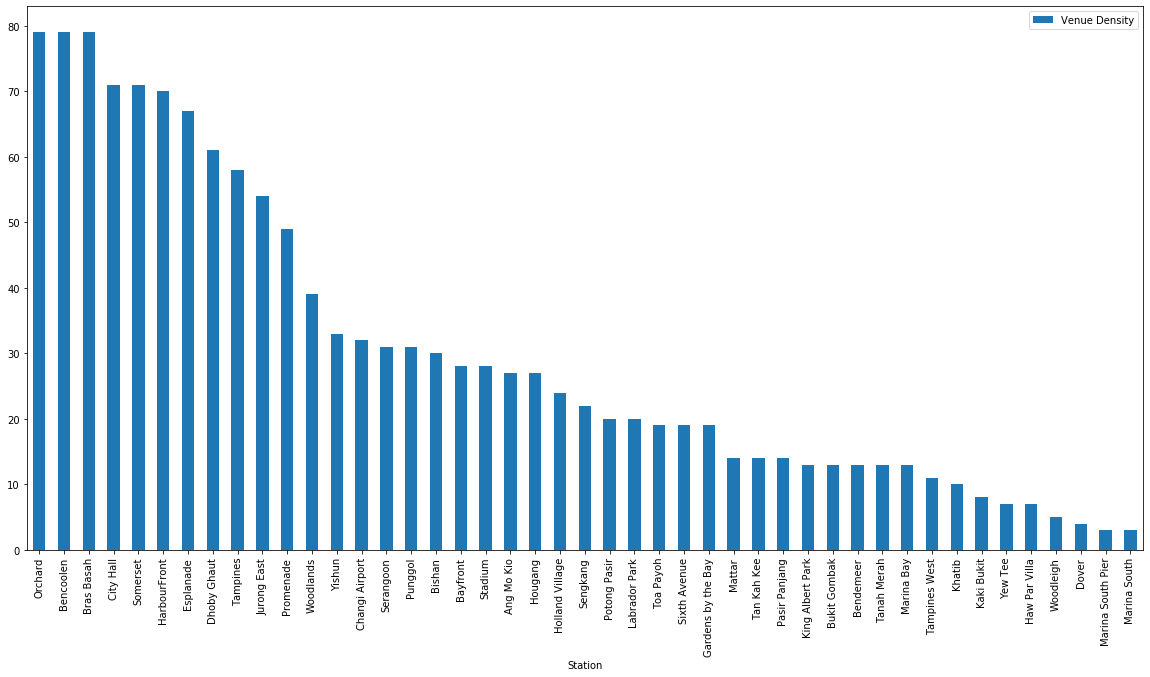

In [107]:
c0den = clusterdensity.drop(clusterdensity[(clusterdensity['Cluster Numbers'] != 0)].index)
c0den = c0den.drop(columns=['Cluster Numbers'])
c0den = c0den.sort_values('Venue Density',ascending=False)
c0den.plot.bar(figsize=(20,10),x='Station')

Let's take the stations that have more than 60% of the top venue density

In [108]:
c0count = c0den['Station'].count()
c0den = c0den.reset_index(drop=True)
c0c = c0den.loc[0]['Venue Density']
c0den[c0den['Venue Density']>(c0c*0.70)]

,Station,Venue Density
0,Orchard,79.0
1,Bencoolen,79.0
2,Bras Basah,79.0
3,City Hall,71.0
4,Somerset,71.0
5,HarbourFront,70.0
6,Esplanade,67.0
7,Dhoby Ghaut,61.0
8,Tampines,58.0


Now i'm going to add a flag to each venue depending upon whether it is in the high or low density buckets

In [109]:
c0den.head()

,Station,Venue Density
0,Orchard,79.0
1,Bencoolen,79.0
2,Bras Basah,79.0
3,City Hall,71.0
4,Somerset,71.0


In [110]:
for x in c0den.index:
    if c0den.loc[x]['Venue Density'] > (c0c*0.70):
        c0den.loc[x,'Density Group'] = 'Top'
    else:
        c0den.loc[x,'Density Group'] = 'Other'


In [111]:
c0den.head()

,Station,Venue Density,Density Group
0,Orchard,79.0,Top
1,Bencoolen,79.0,Top
2,Bras Basah,79.0,Top
3,City Hall,71.0,Top
4,Somerset,71.0,Top


These are the top venues:

In [112]:
c0den[c0den['Density Group'] == 'Top']

,Station,Venue Density,Density Group
0,Orchard,79.0,Top
1,Bencoolen,79.0,Top
2,Bras Basah,79.0,Top
3,City Hall,71.0,Top
4,Somerset,71.0,Top
5,HarbourFront,70.0,Top
6,Esplanade,67.0,Top
7,Dhoby Ghaut,61.0,Top
8,Tampines,58.0,Top


### Venue density for cluster 2 Sports, Recreation & Other

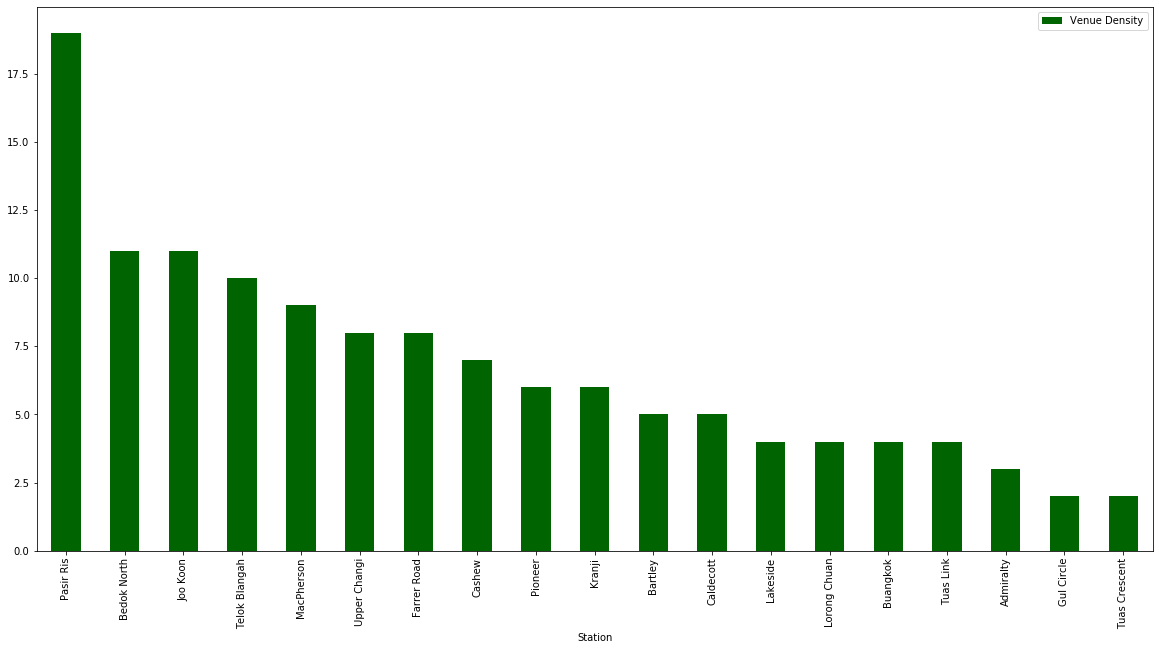

In [113]:
c1den = clusterdensity.drop(clusterdensity[(clusterdensity['Cluster Numbers'] != 1)].index)
c1den = c1den.drop(columns=['Cluster Numbers'])
c1den = c1den.sort_values('Venue Density',ascending=False)
c1den.plot.bar(figsize=(20,10),x='Station',color='darkgreen')

Let's take the stations that have more than 60% of the top venue density

In [114]:
c1count = c1den['Station'].count()
c1den = c1den.reset_index(drop=True)
c1c = c1den.loc[0]['Venue Density']
c1den[c1den['Venue Density']>(c1c*0.70)]

,Station,Venue Density
0,Pasir Ris,19.0


Now i'm going to add a flag to each venue depending upon whether it is in the high or low density buckets

In [115]:
c1den.head()

,Station,Venue Density
0,Pasir Ris,19.0
1,Bedok North,11.0
2,Joo Koon,11.0
3,Telok Blangah,10.0
4,MacPherson,9.0


In [116]:
for x in c1den.index:
    if c1den.loc[x]['Venue Density'] > (c1c*0.70):
        c1den.loc[x,'Density Group'] = 'Top'
    else:
        c1den.loc[x,'Density Group'] = 'Other'

        

In [117]:
c1den.head()

,Station,Venue Density,Density Group
0,Pasir Ris,19.0,Top
1,Bedok North,11.0,Other
2,Joo Koon,11.0,Other
3,Telok Blangah,10.0,Other
4,MacPherson,9.0,Other


These are the top venues:

In [118]:
c1den[c1den['Density Group'] == 'Top']

,Station,Venue Density,Density Group
0,Pasir Ris,19.0,Top


### Venue density for cluster 3 Social & Other

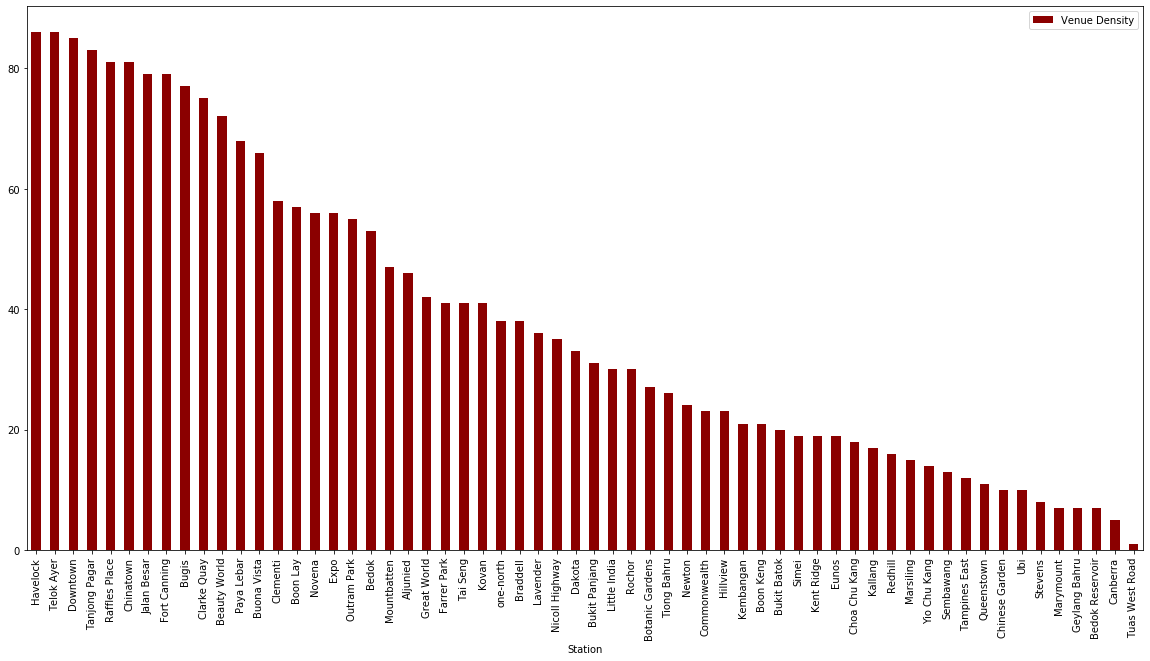

In [119]:
c2den = clusterdensity.drop(clusterdensity[(clusterdensity['Cluster Numbers'] != 2)].index)
c2den = c2den.drop(columns=['Cluster Numbers'])
c2den = c2den.sort_values('Venue Density',ascending=False)
c2den.plot.bar(figsize=(20,10),x='Station',color='darkred')

Let's take the stations that have more than 60% of the top venue density

In [120]:
c2count = c2den['Station'].count()
c2den = c2den.reset_index(drop=True)
c2c = c2den.loc[0]['Venue Density']
c2den[c2den['Venue Density']>(c2c*0.7)]

,Station,Venue Density
0,Havelock,86.0
1,Telok Ayer,86.0
2,Downtown,85.0
3,Tanjong Pagar,83.0
4,Raffles Place,81.0
5,Chinatown,81.0
6,Jalan Besar,79.0
7,Fort Canning,79.0
8,Bugis,77.0
9,Clarke Quay,75.0


Now i'm going to add a flag to each venue depending upon whether it is in the high or low density buckets

In [121]:
c1den.head()

,Station,Venue Density,Density Group
0,Pasir Ris,19.0,Top
1,Bedok North,11.0,Other
2,Joo Koon,11.0,Other
3,Telok Blangah,10.0,Other
4,MacPherson,9.0,Other


In [122]:
for x in c2den.index:
    if c2den.loc[x]['Venue Density'] > (c2c*0.70):
        c2den.loc[x,'Density Group'] = 'Top'
    else:
        c2den.loc[x,'Density Group'] = 'Other'

        

In [123]:
c2den.head()

,Station,Venue Density,Density Group
0,Havelock,86.0,Top
1,Telok Ayer,86.0,Top
2,Downtown,85.0,Top
3,Tanjong Pagar,83.0,Top
4,Raffles Place,81.0,Top


These are the top venues:

In [124]:
c2den[c2den['Density Group'] == 'Top']

,Station,Venue Density,Density Group
0,Havelock,86.0,Top
1,Telok Ayer,86.0,Top
2,Downtown,85.0,Top
3,Tanjong Pagar,83.0,Top
4,Raffles Place,81.0,Top
5,Chinatown,81.0,Top
6,Jalan Besar,79.0,Top
7,Fort Canning,79.0,Top
8,Bugis,77.0,Top
9,Clarke Quay,75.0,Top


I now aggregate the 3 datasets together

In [125]:
callden = pd.concat([c0den, c1den], ignore_index=True)
callden = pd.concat([callden, c2den], ignore_index=True)

In [126]:
callden.shape

(124, 3)

In [127]:
callden.head()

,Station,Venue Density,Density Group
0,Orchard,79.0,Top
1,Bencoolen,79.0,Top
2,Bras Basah,79.0,Top
3,City Hall,71.0,Top
4,Somerset,71.0,Top


This is ready to be further aggregated into the final dataset

## Now we add the Hotel Rank and Venue Density results into the main Dataframe, in order to see final results and draw a map for visualisation

First it's the hotels

In [128]:
sg_withhotel = sg_clusters

In [129]:
sg_withhotel.head()

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Cluster Numbers
0,Admiralty,1.440609,103.800941,"Sports, Recreation & Other",Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels,1
1,Aljunied,1.316416,103.882805,Social & Other,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students,2
2,Ang Mo Kio,1.369985,103.849606,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels,0
3,Bartley,1.342859,103.879682,"Sports, Recreation & Other",Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels,1
4,Bayfront,1.281340,103.858947,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students,0


In [130]:
sg_withhotel = sg_withhotel.merge(hotelcount,how='left', left_on='Station',right_on='Station')


In [131]:
sg_withhotel = sg_withhotel.fillna('NaN')

In [132]:
sg_withhotel.head()

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Cluster Numbers,Hotels,Group
0,Admiralty,1.440609,103.800941,"Sports, Recreation & Other",Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels,1,NaN,NaN
1,Aljunied,1.316416,103.882805,Social & Other,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students,2,1,Low
2,Ang Mo Kio,1.369985,103.849606,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels,0,NaN,NaN
3,Bartley,1.342859,103.879682,"Sports, Recreation & Other",Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels,1,NaN,NaN
4,Bayfront,1.281340,103.858947,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students,0,5,Medium


Now we add venue density tags to the data

In [133]:
sg_final = sg_withhotel.merge(callden,how='left', left_on='Station',right_on='Station')

In [134]:
sg_final.head()

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Cluster Numbers,Hotels,Group,Venue Density,Density Group
0,Admiralty,1.440609,103.800941,"Sports, Recreation & Other",Other,Social,Students,Sport/Recreation,Shopping/Sightseeing,Hotels,1,NaN,NaN,3.0,Other
1,Aljunied,1.316416,103.882805,Social & Other,Social,Other,Sport/Recreation,Shopping/Sightseeing,Hotels,Students,2,1,Low,46.0,Other
2,Ang Mo Kio,1.369985,103.849606,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Sport/Recreation,Students,Hotels,0,NaN,NaN,27.0,Other
3,Bartley,1.342859,103.879682,"Sports, Recreation & Other",Social,Other,Sport/Recreation,Students,Shopping/Sightseeing,Hotels,1,NaN,NaN,5.0,Other
4,Bayfront,1.281340,103.858947,"Social, Shopping & Sightseeing",Social,Other,Shopping/Sightseeing,Hotels,Sport/Recreation,Students,0,5,Medium,28.0,Other


I will set up the following map to show stations tagged as 'Top' for venue density.  They will be highlighted via the size of their marker.  Top stations are large, and Other stations are small.

Now we draw the map

In [135]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbows = {1:'darkblue',2:'darkgreen',3:'darkred','High':'yellow','Medium':'orange','Low':'lightgrey', 'NaN': 'lightgrey'}
dencolor = {'Top': 12, 'Other': 7}
denrad =  {'Top': 1, 'Other': 0.65}

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, clustnum, hotels, dengroup in zip(sg_final['Latitude'], sg_final['Longitude'], sg_final['Station'], sg_final['Cluster Labels'], sg_final['Cluster Numbers'], sg_final['Group'], sg_final['Density Group']):
    label = folium.Popup(str(poi) + ': ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=dencolor[dengroup],
        popup=label,
        opacity=1,
        color='darkgrey',
        fill=True,
        fill_color=rainbows[clustnum+1],
        fill_opacity=1
        ).add_to(map_clusters)

map_clusters

I will now add further to the map by colouring each marker according to density of hotels nearby.

Now we re-draw the map with Hotel Density also included

## Final map/visualisation of results

In [136]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbows = {1:'darkblue',2:'darkgreen',3:'darkred','High':'yellow','Medium':'orange','Low':'lightgrey', 'NaN': 'lightgrey'}
dencolor = {'Top': 12, 'Other': 7}
denrad =  {'Top': 1, 'Other': 0.65}

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, clustnum, hotels, dengroup in zip(sg_final['Latitude'], sg_final['Longitude'], sg_final['Station'], sg_final['Cluster Labels'], sg_final['Cluster Numbers'], sg_final['Group'], sg_final['Density Group']):
    label = folium.Popup(str(poi) + ': ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=dencolor[dengroup],
        popup=label,
        opacity=1,
        color=rainbows[hotels],
        fill=True,
        fill_color=rainbows[clustnum+1],
        fill_opacity=denrad[dengroup]
        ).add_to(map_clusters)

map_clusters

Given the concentration of high-density stations in the South-Central it is useful to further zoom in on that area in order to see more clearly what is going on (see below).

In [137]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbows = {1:'darkblue',2:'darkgreen',3:'darkred','High':'yellow','Medium':'orange','Low':'lightgrey', 'NaN': 'lightgrey'}
dencolor = {'Top': 12, 'Other': 7}
denrad =  {'Top': 1, 'Other': 0.65}

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, clustnum, hotels, dengroup in zip(sg_final['Latitude'], sg_final['Longitude'], sg_final['Station'], sg_final['Cluster Labels'], sg_final['Cluster Numbers'], sg_final['Group'], sg_final['Density Group']):
    label = folium.Popup(str(poi) + ': ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=dencolor[dengroup],
        popup=label,
        opacity=1,
        color=rainbows[hotels],
        fill=True,
        fill_color=rainbows[clustnum+1],
        fill_opacity=denrad[dengroup]
        ).add_to(map_clusters)

map_clusters

In [138]:
sg_report = sg_final.drop(columns=['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue',])
sg_report.head()

,Station,Latitude,Longitude,Cluster Labels,Cluster Numbers,Hotels,Group,Venue Density,Density Group
0,Admiralty,1.440609,103.800941,"Sports, Recreation & Other",1,NaN,NaN,3.0,Other
1,Aljunied,1.316416,103.882805,Social & Other,2,1,Low,46.0,Other
2,Ang Mo Kio,1.369985,103.849606,"Social, Shopping & Sightseeing",0,NaN,NaN,27.0,Other
3,Bartley,1.342859,103.879682,"Sports, Recreation & Other",1,NaN,NaN,5.0,Other
4,Bayfront,1.281340,103.858947,"Social, Shopping & Sightseeing",0,5,Medium,28.0,Other


# Results

### Where is best for different activities

It is interesting to see that the types of activities available across the island are well distributed (all activities are available to some degree across the island). However there appears to be a large number of high-density stations located in the South-Central area of Singapore. In particular the South-Central region appears to contain:

-	All of the stations that are surrounded by a high / medium number of hotels
-	A large number of stations that are particularly good for people looking for Social activities as well as Shopping and Sightseeing

A further detailed look at this area (as seen in the more detailed map above) suggests that there are two clear primary clusters in the South-Central area that are good for tourists:

-	The area from Orchard to City Hall (upper middle section of the map) is a particularly good area for people looking for Social, Shopping and Sightseeing activities.
-	The area from Fort Canning to Downtown / Tanjong Pagar (lower middle section of the map) is a particularly good area for people looking for Social activities.

Having said this, as mentioned above there is a good distribution of activities across the island. Firstly, outside of the areas highlighted above there are other stations that are away from the obvious cluster pockets but still have a high density of venues e.g. Harbourfront (good for Social, Shopping & Sightseeing) in the far South or Pasir Ris (good for Sports & Recreation) in the far East. Therefore, for those tourists looking for places to stay that are away from the crowd but still lots to do, there are definitely options for them that are clear from the analysis in this project. 

Further, some people may well be explicitly looking for areas in Singapore where it is possible to experience certain activities but with fewer people (or cheaper hotel prices), and this analysis can potentially help to identify where those places can be found e.g. Outram Park station:


### Hotel Density

This analysis has demonstrated those areas where hotel density is high, which makes it possible for tourists to select a station that meets their needs in terms of both of activity and hotel availability, for example Chinatown has a high number of hotels nearby and is also one of the best stations in Singapore for enjoying Social activities. 

Conversely, and as eluded to in the introduction, this could be useful to hotel business owners to identify areas which have a high density of venues but low hotels in the vicinity, for example Harbourfront is densely packed with venues, is particularly good for tourists looking for Social, Shopping & Sightseeing, however the number of hotels nearby is low.  This may represent an opportunity.


### Further opportunities for analysis

There are certainly multiple opportunities to build upon this analysis, for example:

-	It could be interesting to break down the ‘Social’ category to give more context to sub-activities e.g. Restaurants vs. Bars vs. Clubs.  
-	Further, it would be interesting to consider the density of different restaurant / cuisine types (e.g. local Singaporean vs. Italian)
-	Alternatively, it would be interesting to consider hotel prices to see best value areas
-	It would even be possible to widen the objective to other people e.g. residents of Singapore; where is best to live for different job types?


# Conclusion

The basis of this project was to identify those stations that would be best suited to tourists, and looking at the results it is fair to say that the analysis has been successful.

Activities are generally well distributed across the island (all activities are available to some degree in each region). However, the South-Central region is clearly where the action is at, particularly with respect to Social activities as well as Shopping and Sightseeing. The South-Central is also where tourists should look for hotels. 

For Sports and Recreation activities there appears to be options across the island (Pasir Ris being the best) although being located in the South-Central region may still be the best for access to Hotels and other activities.
It is clear there are many ways to expand upon the analysis here, either by improving the data / analysis itself or by widening / modifying the objective to suit other needs.
